In [1]:
# Core libraries
import pandas as pd
import numpy as np
import re

# NLP & clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Transformers
from transformers import pipeline
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


c:\Users\siboham\Desktop\GooglePlayReviews\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
df = pd.read_csv("googleplaystore_user_reviews.csv")  # Adjust path if needed

# Basic cleaning function
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', str(text))  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip()

# Apply cleaning to 'content' column
df['cleaned'] = df['content'].apply(clean_text)

# Drop rows with empty or null cleaned text
df = df[df['cleaned'].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)

# Preview
df[['content', 'cleaned']].head()


,content,cleaned
0,I cannot open the app anymore,i cannot open the app anymore
1,I have been begging for a refund from this app...,i have been begging for a refund from this app...
2,Very costly for the premium version (approx In...,very costly for the premium version approx ind...
3,"Used to keep me organized, but all the 2020 UP...",used to keep me organized but all the updates...
4,Dan Birthday Oct 28,dan birthday oct


In [3]:
df.shape

(12463, 13)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
tfidf = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')

# Fit and transform the cleaned reviews
X_tfidf = tfidf.fit_transform(df['cleaned'])

# Print shape for sanity check
print(f"TF-IDF matrix shape: {X_tfidf.shape}")


TF-IDF matrix shape: (12463, 1744)


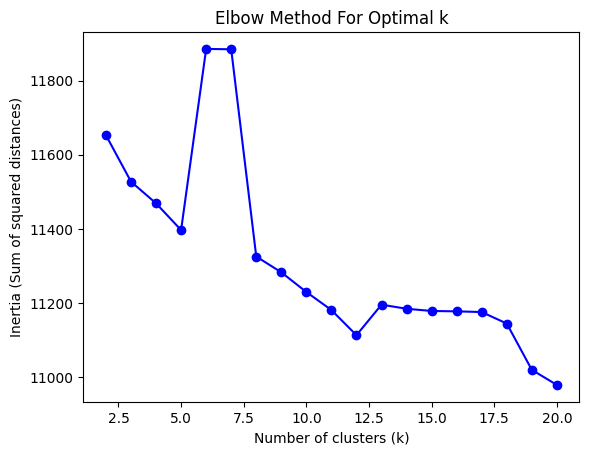

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(2, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Evaluate clustering quality
score = silhouette_score(X_tfidf, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.027


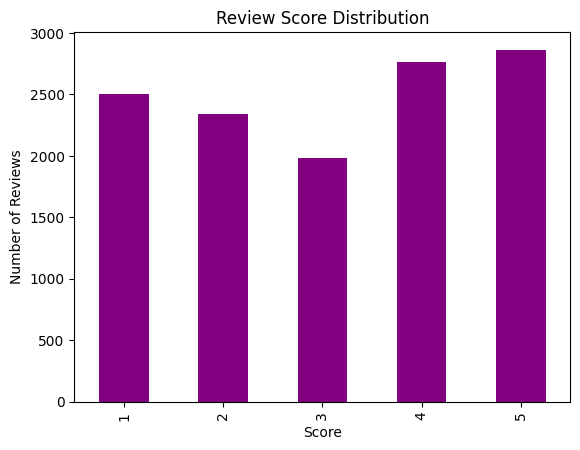

In [28]:
# Score distribution
import matplotlib.pyplot as plt

df['score'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Review Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.show()

In [6]:
# Get feature names from TF-IDF
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Print top 10 terms per cluster
for i in range(10):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Cluster 0: students, superb, app, good, useful, like, nice, dont, use, amazing
Cluster 1: tasks, time, task, app, list, day, add, like, set, just
Cluster 2: app, love, like, nice, good, version, really, work, best, premium
Cluster 3: working, app, stopped, properly, notifications, widget, good, really, phone, notification
Cluster 4: good, app, far, pretty, apps, use, really, application, quite, job
Cluster 5: great, app, nice, tool, love, really, far, day, life, works
Cluster 6: excellent, app, easy, planner, helpful, use, features, calendar, application, daily
Cluster 7: habits, track, app, good, habit, free, like, great, tracking, new
Cluster 8: easy, use, simple, app, good, helpful, useful, great, love, nice
Cluster 9: calendar, google, app, sync, events, use, like, dont, ads, tasks


In [7]:
# Sample 3 reviews from each of the first 5 clusters
for i in range(5):
    print(f"\n📌 Cluster {i} Samples:")
    samples = df[df['cluster'] == i]['content'].sample(3, random_state=42).to_list()
    for idx, review in enumerate(samples, 1):
        print(f"{idx}. {review}")



📌 Cluster 0 Samples:
1. Fun for university students The only problem is they don't order the tasks by date, do you have to be careful not to miss homework. Now that i think about it, it's actually a big problem for students using the app. It is fun, overall, and I do homework to keep my avatars alive. Think Tamagotchi
2. It is a superb app I like this app very much
3. include monthly to do list. which helps students to create timetable.

📌 Cluster 1 Samples:
1. Installed this app, added the tasks, logged in using google in the same order. But after login the tasks added no more found. This is definitely unacceptable.
2. Good app and I like the setups that are already prepared for when u log in. My problem with the app is that it's too overwhelming. Too many things to manage and for my easily distracted and anxious brain it's too much. As constructive that can actually be applied--please make it so the tasks actually leave the list ocne they are completed. Some are infinite and its dif

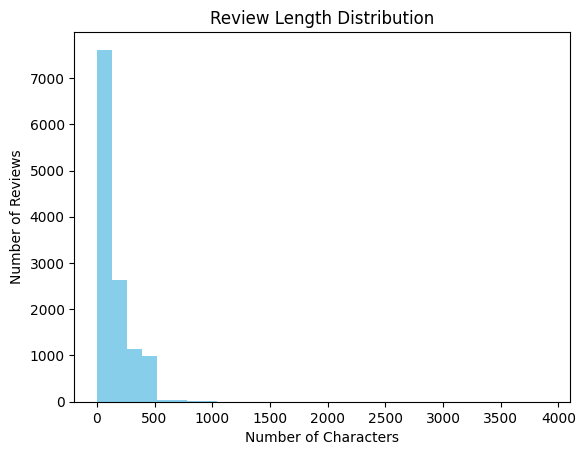

In [26]:
# Review length distribution
import matplotlib.pyplot as plt

df['review_length'] = df['cleaned'].str.len()
plt.hist(df['review_length'], bins=30, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Reviews')
plt.show()

In [10]:
from transformers import pipeline

# Load Flan-T5 model for text2text generation
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Example vague review
vague_review = "App crashes often and doesn't load properly"
prompt = f"Respond to user complaint: '{vague_review}'"

# Generate response
response = generator(prompt, max_length=150, do_sample=True)
print("Generated Response:", response[0]['generated_text'])



Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated Response: It crashes often and doesn't load properly.


In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load sentence transformer model for embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings from cleaned reviews
embeddings = embedding_model.encode(df['cleaned'].tolist(), show_progress_bar=True)

# Fit BERTopic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['cleaned'].tolist(), embeddings)

# Assign topics to DataFrame
df['bertopic_cluster'] = topics

# Show top 10 topics
topic_model.get_topic_info().head(10)


Batches: 100%|██████████| 390/390 [03:48<00:00,  1.71it/s]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4113,-1_to_the_and_it,"[to, the, and, it, for, is, app, this, of, my]",[its a good app i do use it alot but there are...
1,0,641,0_calendar_google_calendars_events,"[calendar, google, calendars, events, sync, ca...","[good calendar app, cant sync with google cale..."
2,1,320,1_habit_habits_track_tracker,"[habit, habits, track, tracker, tracking, only...","[only habit you can update, you can only add ..."
3,2,271,2_helps_track_organized_me,"[helps, track, organized, me, keep, keeps, sta...",[i find it very helpful to keep track of my da...
4,3,244,3_trees_tree_coins_forest,"[trees, tree, coins, forest, pro, plant, speci...","[i like trees, i loved this app a lot however ..."
5,4,193,4_crashing_crashes_open_keeps,"[crashing, crashes, open, keeps, crash, downlo...","[the app keeps crashing on me, keeps crashing ..."
6,5,170,5_ads_full_ad_screen,"[ads, full, ad, screen, annoying, video, intru...","[ads, ads ads ads, ads]"
7,6,156,6_planner_paper_planners_digital,"[planner, paper, planners, digital, agenda, ar...","[good planner apps, best time planner, great p..."
8,7,152,7_task_tasks_delete_subtasks,"[task, tasks, delete, subtasks, completed, sub...",[very long time user latest updates are making...
9,8,148,8_rpg_game_life_fun,"[rpg, game, life, fun, you, gamification, more...",[excellent idea but poor execution there reall...


In [12]:
from gsdmm import MovieGroupProcess
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize reviews for GSDMM
df['tokens'] = df['cleaned'].apply(lambda x: x.split())

# Initialize GSDMM
mgp = MovieGroupProcess(K=20, alpha=0.1, beta=0.3, n_iters=30)

# Fit model
vocab = set(word for doc in df['tokens'] for word in doc)
n_terms = len(vocab)
doc_list = df['tokens'].tolist()

mgp.fit(doc_list, n_terms)

# Assign cluster labels
df['gsdmm_cluster'] = [mgp.choose_best_label(doc)[0] for doc in doc_list]

# Show top 10 clusters
from collections import Counter
print("Top GSDMM clusters:", Counter(df['gsdmm_cluster']).most_common(10))


In stage 0: transferred 11595 clusters with 20 clusters populated
In stage 1: transferred 7392 clusters with 20 clusters populated
In stage 2: transferred 3216 clusters with 19 clusters populated
In stage 3: transferred 2054 clusters with 16 clusters populated
In stage 4: transferred 1716 clusters with 14 clusters populated
In stage 5: transferred 1620 clusters with 11 clusters populated
In stage 6: transferred 1571 clusters with 11 clusters populated
In stage 7: transferred 1632 clusters with 11 clusters populated
In stage 8: transferred 1600 clusters with 9 clusters populated
In stage 9: transferred 1583 clusters with 9 clusters populated
In stage 10: transferred 1637 clusters with 10 clusters populated
In stage 11: transferred 1605 clusters with 9 clusters populated
In stage 12: transferred 1569 clusters with 9 clusters populated
In stage 13: transferred 1576 clusters with 9 clusters populated
In stage 14: transferred 1656 clusters with 9 clusters populated
In stage 15: transferred 

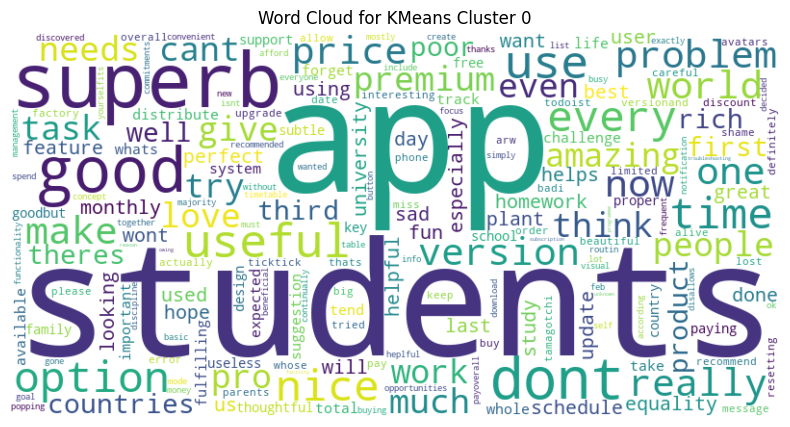

In [30]:
# Word cloud for a selected cluster (e.g., KMeans cluster 0)
from wordcloud import WordCloud

cluster_num = 0  # Change as needed
text = ' '.join(df[df['cluster'] == cluster_num]['cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for KMeans Cluster {cluster_num}')
plt.show()

In [13]:
from collections import Counter

# TF-IDF + KMeans
print("\n🔹 TF-IDF + KMeans:")
print("Top clusters:", Counter(df['cluster']).most_common(5))

# BERTopic
print("\n🔹 BERTopic:")
print("Top topics:", Counter(df['bertopic_cluster']).most_common(5))

# GSDMM
print("\n🔹 GSDMM:")
print("Top clusters:", Counter(df['gsdmm_cluster']).most_common(5))



🔹 TF-IDF + KMeans:
Top clusters: [(2, 7414), (1, 2421), (9, 660), (5, 450), (8, 430)]

🔹 BERTopic:
Top topics: [(-1, 4113), (0, 641), (1, 320), (2, 271), (3, 244)]

🔹 GSDMM:
Top clusters: [(18, 7636), (17, 4393), (11, 122), (19, 110), (0, 64)]


In [14]:
# Filter vague reviews: short length or low score
vague_df = df[(df['score'] <= 2) | (df['cleaned'].str.len() < 40)].copy()

# Load Flan-T5 pipeline
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Generate responses for first 5 vague reviews
for i, row in vague_df.head(5).iterrows():
    prompt = f"Respond to user complaint: '{row['content']}'"
    response = generator(prompt, max_length=50, do_sample=True)
    print(f"\n🗣️ Original: {row['content']}")
    print(f"🤖 Response: {response[0]['generated_text']}")


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🗣️ Original: I cannot open the app anymore
🤖 Response:                                                                                                                                


Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🗣️ Original: I have been begging for a refund from this app for over a month and nobody is replying me
🤖 Response: I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month and nobody is replying me. I have been begging for a refund from this app for over a month a

Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🗣️ Original: Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤
🤖 Response: 'I used to keep me organized , but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!!

🗣️ Original: Dan Birthday Oct 28
🤖 Response: Dan's birthday is on Oct 28.


In [15]:
# Select relevant columns for export
export_cols = [
    'reviewId', 'userName', 'content', 'score',
    'cleaned', 'cluster', 'bertopic_cluster', 'gsdmm_cluster'
]

# Export to CSV
df[export_cols].to_csv("revai_clustered_reviews.csv", index=False)

print("✅ Export complete: revai_clustered_reviews.csv")


✅ Export complete: revai_clustered_reviews.csv


In [16]:
from tqdm import tqdm
from transformers import pipeline

# Reload Flan-T5 pipeline if needed
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Filter vague reviews (short or low score)
vague_df = df[(df['score'] <= 2) | (df['cleaned'].str.len() < 40)].copy()

# Sort by score ascending, then length ascending
vague_df['length'] = vague_df['cleaned'].str.len()
vague_df = vague_df.sort_values(by=['score', 'length']).head(100)

# Initialize response column
vague_df['flan_response'] = ""

# Generate responses
for i, row in tqdm(vague_df.iterrows(), total=len(vague_df)):
    prompt = f"Respond to user complaint: '{row['content']}'"
    try:
        response = generator(prompt, max_length=50, do_sample=True)
        vague_df.at[i, 'flan_response'] = response[0]['generated_text']
    except Exception as e:
        vague_df.at[i, 'flan_response'] = "Error generating response"

# Merge responses back into main DataFrame
df = df.merge(vague_df[['reviewId', 'flan_response']], on='reviewId', how='left')

# Export final enriched dataset
df.to_csv("revai_clustered_with_responses.csv", index=False)
print("✅ Export complete: revai_clustered_with_responses.csv")


Device set to use cpu
100%|██████████| 100/100 [59:02<00:00, 35.43s/it]


✅ Export complete: revai_clustered_with_responses.csv


In [17]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

# Train Word2Vec on tokenized reviews
tokenized_reviews = df['cleaned'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=5, workers=4)

# Create sentence embeddings by averaging word vectors
def get_sentence_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

df['w2v_vector'] = tokenized_reviews.apply(get_sentence_vector)

# Stack vectors into matrix
X_w2v = np.vstack(df['w2v_vector'].values)

# Cluster using KMeans
w2v_kmeans = KMeans(n_clusters=10, random_state=42)
df['w2v_cluster'] = w2v_kmeans.fit_predict(X_w2v)

print("✅ Word2Vec clustering complete. Sample clusters:", df['w2v_cluster'].value_counts().head())


✅ Word2Vec clustering complete. Sample clusters: w2v_cluster
9    2967
4    2898
3    2180
1    1766
0    1003
Name: count, dtype: int64


In [18]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="distilbert-base-uncased")

# Define labels
labels = ["vague", "detailed"]

# Classify first 10 reviews
df['distilbert_label'] = ""

for i, row in df.head(10).iterrows():
    result = classifier(row['content'], candidate_labels=labels)
    df.at[i, 'distilbert_label'] = result['labels'][0]

print(df[['content', 'distilbert_label']].head(10))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


                                             content distilbert_label
0                      I cannot open the app anymore         detailed
1  I have been begging for a refund from this app...         detailed
2  Very costly for the premium version (approx In...            vague
3  Used to keep me organized, but all the 2020 UP...            vague
4                                Dan Birthday Oct 28            vague
5  It has changed how I viewed my different lists...            vague
6  I'm only looking for a grocery list app but ev...            vague
7  Reset my free trial, new phone I'd like to see...            vague
8  How do to stop monthly payment because i don't...            vague
9  I complain about not crashes and it was immedi...            vague


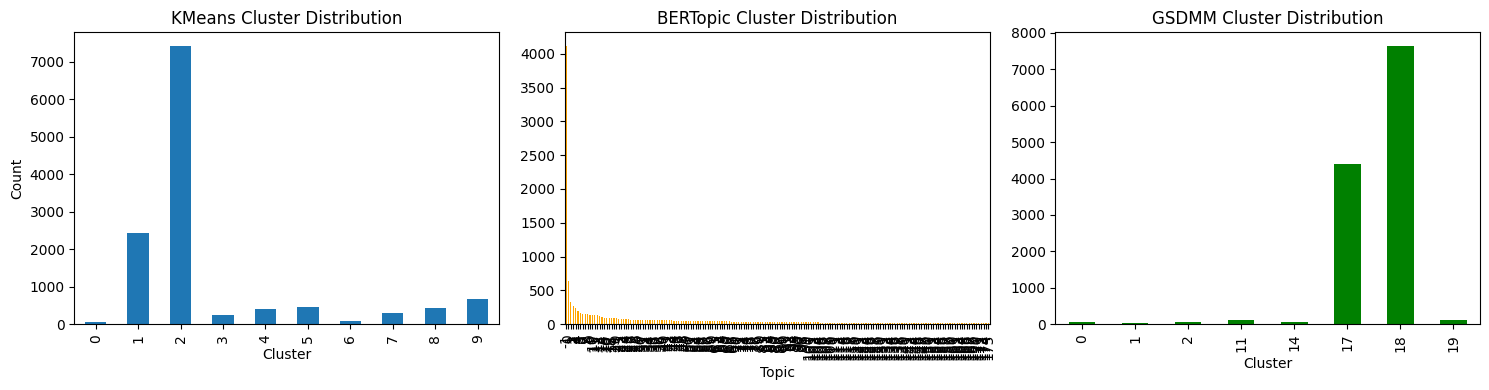

In [25]:
# Visualize cluster distribution for KMeans, BERTopic, and GSDMM
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
df['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('KMeans Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
df['bertopic_cluster'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('BERTopic Cluster Distribution')
plt.xlabel('Topic')

plt.subplot(1, 3, 3)
df['gsdmm_cluster'].value_counts().sort_index().plot(kind='bar', color='green')
plt.title('GSDMM Cluster Distribution')
plt.xlabel('Cluster')

plt.tight_layout()
plt.show()

In [ ]:
# from tqdm import tqdm

# Reload Flan-T5 pipeline if needed
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Filter reviews labeled as vague
vague_reviews = df[df['distilbert_label'] == "vague"].copy()
vague_reviews['flan_response'] = ""

# Generate responses
for i, row in tqdm(vague_reviews.iterrows(), total=len(vague_reviews)):
    prompt = f"Respond to user complaint: '{row['content']}'"
    try:
        response = generator(prompt, max_length=50, do_sample=True)
        vague_reviews.at[i, 'flan_response'] = response[0]['generated_text']
    except Exception:
        vague_reviews.at[i, 'flan_response'] = "Error generating response"

# Merge responses back into main DataFrame
df = df.merge(vague_reviews[['reviewId', 'flan_response']], on='reviewId', how='left')

print("✅ Flan-T5 responses generated for 100 most vague reviews only.")


Device set to use cpu
100%|██████████| 8/8 [04:05<00:00, 30.64s/it]

✅ Flan-T5 responses generated for vague reviews only.


In [24]:
# Export enriched dataset with all clusters and responses
df.to_csv("revai_full_pipeline_output.csv", index=False)
print("📦 Final export complete: revai_full_pipeline_output.csv")


📦 Final export complete: revai_full_pipeline_output.csv


In [23]:
from tqdm import tqdm
from transformers import pipeline

# Reload Flan-T5 pipeline if needed
generator = pipeline("text2text-generation", model="google/flan-t5-base")

# Filter reviews labeled as vague
vague_reviews = df[df['distilbert_label'] == "vague"].copy()
vague_reviews['followup_question'] = ""

# Generate follow-up questions
for i, row in tqdm(vague_reviews.iterrows(), total=len(vague_reviews)):
    prompt = f"Given the user review: '{row['content']}', ask a follow-up question to get more details about the review. Ask the user to explain their problem in more details."
    try:
        response = generator(prompt, max_length=50, do_sample=True)
        vague_reviews.at[i, 'followup_question'] = response[0]['generated_text']
    except Exception:
        vague_reviews.at[i, 'followup_question'] = "Error generating question"

# Merge follow-up questions back into main DataFrame
df = df.merge(vague_reviews[['reviewId', 'followup_question']], on='reviewId', how='left')

Device set to use cpu
100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


In [22]:
# Export enriched dataset with all clusters and responses
df.to_csv("revai_followup_questions.csv", index=False)
print("📦 Final export complete: revai_full_pipeline_output.csv")

📦 Final export complete: revai_full_pipeline_output.csv
